# Orchestration OFF v ON
### This notebook tests multi-agent graphs with orchestration OFF and ON

---


# Shared Code

In [1]:
# =====================================================
# === 1. imports (12 LOC) =============================
# =====================================================
import cudf.pandas
cudf.pandas.install()
import pandas as pd

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List
import operator

In [2]:
# =====================================================
# === 2. LLM setup (2 LOC) ============================
# =====================================================
# Load environment variables from .env file
load_dotenv(override=True)

llm = ChatOpenAI(
    model="qwen/qwen3-coder-480b-a35b-instruct",
    api_key=os.getenv("NVIDIA_API_KEY"),
    base_url="https://integrate.api.nvidia.com/v1",
    temperature=0.1,
    max_tokens=500,
)

In [3]:
# =====================================================
# === 3. Data ( 1 LOC ) ===============================
# =====================================================
# Toy, Sample DataFrame
df = pd.DataFrame({
    'date': pd.date_range('2024-01-01', periods=10),
    'sales': [1_000_000, 120, 115, 140, 160, 155, 180, 190, 185, 200],
    'profit': [20, 25, 23, 30, 35, 33, 40, 42, 41, 45]
})

---

# Orchestration OFF

In [4]:
# =====================================================
# === 4. Tools ( 4 LOC ) ==============================
# =====================================================
# Define tool to execute Python code
@tool
def execute_python(code: str) -> str:
    """Execute Python code to analyze the DataFrame 'df'.
    Variables available: df (pandas DataFrame), pd (pandas module).
    Store your result in a variable called 'result' to return it.
    """
    try:
        local_vars = {"df": df, "pd": pd}
        exec(code, {"__builtins__": __builtins__, "pd": pd}, local_vars)
        return str(local_vars.get("result", "Code executed. Use 'result' variable."))
    except Exception as e:
        return f"Error: {str(e)}"

In [5]:
# =====================================================
# === 5. Nodes ( 9 LOC ) ==============================
# =====================================================
def planner_agent(state: MessagesState):
    """Decides what analysis to perform."""
    system = SystemMessage(content="""You are a planning agent. 
    Analyze the user's question and describe what calculation needs to be done.
    Be specific about the operation (mean, sum, max, etc.) and column.""")
    
    messages = [system] + state["messages"]
    planner_reply = llm.invoke(messages)
    return {
        "messages": [planner_reply]
    }


def coder_agent(state: MessagesState):
    """Generates and executes code/instructions (via tool calls)"""
    system = SystemMessage(content=f"""You are a coding agent.
    DataFrame 'df' has columns: {list(df.columns)}.
    Sample data: {df.head(3).to_string()}
    
    Write Python and pandas code to solve the task.""")
    messages = [system] + state["messages"]
    llm_with_tools = llm.bind_tools([execute_python])
    
    coder_reply = llm_with_tools.invoke(messages)
    return {
        "messages": [coder_reply]
    }

In [6]:
# =====================================================
# === 6. Build Graph ( 9 LOC ) ========================
# =====================================================
"""
ORCHESTRATION OFF:
A simple, static pipeline: START -> planner -> coder -> tools -> END
There is no decision point. We always run tools, even if the coder didn't actually request a tool call.
"""
graph = StateGraph(MessagesState)
graph.add_node("planner", planner_agent)
graph.add_node("coder", coder_agent)
graph.add_node("tools", ToolNode([execute_python]))

# Static linear flow (brittle)
graph.add_edge(START, "planner")
graph.add_edge("planner", "coder")

# ⚠️ BUG: Always routes to tools, even when LLM doesn't request one
graph.add_edge("coder", "tools")

graph.add_edge("tools", END)

orch_OFF = graph.compile()

---

# Orchestration ON

In [7]:
# =================================================================
# === Custom State, Nodes, Routing Logic ( 18 LOC ) ===============
# =================================================================

class AgentState(TypedDict):
    # Conversation history (reducer appends messages)
    messages: Annotated[List[BaseMessage], operator.add]
    # High-level plan from planner node
    plan: str
    # Code string or instructions from coder node
    code: str
    # Final numeric/text result (optional, for demo)
    result: str


def planner_agent_orch(state: AgentState):
    """Decides what analysis to perform and writes a 'plan' into state."""
    system = SystemMessage(content="""You are a planning agent. 
    Analyze the user's question and describe what calculation needs to be done.
    Be specific about the operation (mean, sum, max, etc.) and column.""")
    
    messages = [system] + state["messages"]
    planner_reply = llm.invoke(messages)
    return {
        "messages": [planner_reply],
        "plan": planner_reply.content,
    }


def coder_agent_orch(state: AgentState):
    """Generates and executes code/instructions (via tool calls)"""
    system = SystemMessage(content=f"""You are a coding agent.
    DataFrame 'df' has columns: {list(df.columns)}.
    Sample data: {df.head(3).to_string()}
    
    Write Python and pandas code to solve the task.""")
    messages = [system] + state["messages"]
    llm_with_tools = llm.bind_tools([execute_python])    
    coder_reply = llm_with_tools.invoke(messages)
    # Extract code for state tracking (optional)
    code_str = coder_reply.content or ""
    if hasattr(coder_reply, "tool_calls") and bool(coder_reply.tool_calls):
        code_str = coder_reply.tool_calls[0].get("args", {}).get("code", "")
    
    return {
        "messages": [coder_reply],
        "code": code_str
        }  


def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and bool(last_msg.tool_calls):
        return "tools"    

    return END

In [8]:
# =====================================================
# === 6. Build Graph ( 9 LOC ) ========================
# =====================================================
"""
ORCHESTRATION ON:
Conditional edges and a loop:
    START -> planner -> coder
                    | (if tool_calls) -> tools -> coder
                    | (else) -> END
This graph *decides* whether to call tools or stop, based on the state (tool calls),
and we maintain structured state (plan, coder, result).
"""
orch_graph = StateGraph(AgentState)

orch_graph.add_node("planner", planner_agent_orch)
orch_graph.add_node("coder", coder_agent_orch)
orch_graph.add_node("tools", ToolNode([execute_python]))
# Define flow: START -> Planner -> Coder -> Tools (if needed) -> END
orch_graph.add_edge(START, "planner")
orch_graph.add_edge("planner", "coder")
# Orchestrated decision:
# - if coder produced tool calls -> "tools", otherwise -> END
orch_graph.add_conditional_edges("coder", should_continue, ["tools", END])
# Loop back from tools to coder so multiple tool calls are possible
orch_graph.add_edge("tools", "coder")
orch_ON = orch_graph.compile()

### "Studio" LOL

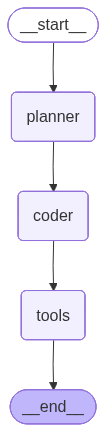

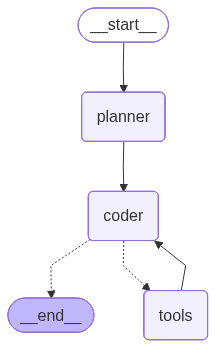

(None, None)

In [9]:
display(orch_OFF),display(orch_ON)

# Head-to-Head

In [11]:
# =====================================================
# === Test Run ========================================
# =====================================================
print('\n\n' + '*'*20 + '\n')

prompt = "What are the average sales?"
print(f'prompt = "{prompt}"\n')
orch_OFF_result = orch_OFF.invoke({"messages": [HumanMessage(content=prompt)]})
orch_ON_result = orch_ON.invoke({"messages": [HumanMessage(content=prompt)]})
print("Orch OFF:", orch_OFF_result['messages'][-1].content, '\n' + '-'*20)
print("Orch ON :", orch_ON_result['messages'][-1].content, '\n')

print('*'*20 + '\n')

prompt = "Say, 'I love AI!'"
print(f'prompt = "{prompt}"\n')
orch_OFF_result = orch_OFF.invoke({"messages": [HumanMessage(content=prompt)]})
orch_ON_result = orch_ON.invoke({"messages": [HumanMessage(content=prompt)]})
print("Orch OFF:", orch_OFF_result['messages'][-1].content, '\n' + '-'*20)
print("Orch ON :", orch_ON_result['messages'][-1].content, '\n')

print('*'*20 + '\n')

prompt = "What's 2+2?"
print(f'prompt = "{prompt}"\n')
orch_OFF_result = orch_OFF.invoke({"messages": [HumanMessage(content=prompt)]})
orch_ON_result = orch_ON.invoke({"messages": [HumanMessage(content=prompt)]})
print("Orch OFF:", orch_OFF_result['messages'][-1].content, '\n' + '-'*20)
print("Orch ON :", orch_ON_result['messages'][-1].content, '\n')



********************

prompt = "What are the average sales?"

Orch OFF: 100144.5 
--------------------
Orch ON : The average sales is 100144.5. 

********************

prompt = "Say, 'I love AI!'"

Orch OFF: I love AI! 
--------------------
Orch ON : None of the provided functions are necessary to fulfill this request. 

********************

prompt = "What's 2+2?"

Orch OFF: {'total_sales': np.int64(1001445), 'total_profit': np.int64(334)} 
--------------------
Orch ON : The result of 2 + 2 is 4. 

